<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/CNN_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tqdm
import torch.distributions as distr

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 8.8 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision
from torchvision import transforms as T
from matplotlib import pyplot as plt

In [4]:
from torch import nn
from torch.nn import functional as F

In [5]:
import functorch as fc
from functorch import jvp
from functools import partial

In [6]:
import time

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [8]:
# This loads data with both data conversion.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=T.ToTensor())

tensor(8)


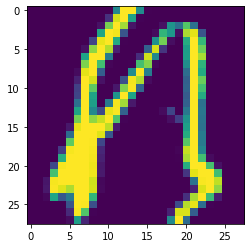

In [9]:
# We visualize the first sample of the dataset
plt.imshow(train_data.data[0])
print(train_data.targets[0])

In [79]:
# We use the loader to shuffle the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

In [11]:
# We get the first element of the loader
xb, yb = next(iter(train_loader))

In [80]:
# Load the testset
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# **Define Convolutional Neural Network**

In [81]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, 2, 3, padding=1)

        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*14*14, 64)

        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.reshape((-1, 4*14*14))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(1, -1)
        return torch.softmax(x, 1)

In [82]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [83]:
# We initialize the parameters randomly and the model with an input size
cnn = SimpleCNN(1)

In [84]:
# Get the functional version of the model with functorch
fcnn, params = fc.make_functional(cnn)
fcnn(params, xb)

tensor([[0.1019, 0.1071, 0.0935, 0.1062, 0.0939, 0.1056, 0.1155, 0.0929, 0.0928,
         0.0907]], grad_fn=<SoftmaxBackward0>)

In [85]:
# We try our model with the first example
print(cnn(xb)[0])

tensor([0.1019, 0.1071, 0.0935, 0.1062, 0.0939, 0.1056, 0.1155, 0.0929, 0.0928,
        0.0907], grad_fn=<SelectBackward0>)



Calculate predictions

In [86]:
def pred(sample_size, loader, model):
  Xtrain = torch.randn(sample_size, 1, 28, 28)
  ytrain = torch.randn(sample_size)
  ypred = torch.randn(sample_size, 10)

  for i in range(sample_size):
    xb, yb = next(iter(loader))
    Xtrain[i] = xb
    ytrain[i] = yb
    ypred[i] = model(xb)

  return Xtrain, ytrain, ypred

In [87]:
Xtrain, ytrain, ypred= pred(500, train_loader, cnn)

# **Define accuracy**

In [88]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue.long()).float().mean()

In [89]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain, ypred)

tensor(0.0860)

# **Define Cross-Entropy**

In [100]:
def cross_entropy(ytrue, ypred):
  print(torch.arange(0, ypred.shape[0]), ytrue.long())
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue.long()].log().mean()

In [91]:
print(cross_entropy(ytrain, cnn(Xtrain)))

tensor(8.5205, grad_fn=<NegBackward0>)


# **Train and evaluate the network**

In [119]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters())
accuracies=[]
losses=[]

t=0
t0 = time.time()
for epoch in range(60):
  
  cnn.train()
  for i in range(499):
    xb, yb=Xtrain[i],ytrain[i]
    xb, yb = xb.to(device), yb.to(device)

    opt.zero_grad()
    ypred = cnn(xb)
    yb = yb.reshape(1)
    l = loss(ypred, yb.long())
    l.backward()
    opt.step()
    
  Xtest, ytest, ypredtest = pred(100, test_loader, cnn)
  accuracies.append(accuracy(ytest,ypredtest).item())
  loss2=0
  for i in range(ypredtest.size(0)):
    loss2+=loss(ypredtest[i], ytest[i].long())
  losses.append((loss2/ypredtest.size(0)).detach().item())

  loss1 = 0
  for i in range(Xtrain.size(0)):
    ytraini = ytrain[i].reshape(1)
    loss1 += loss(cnn(Xtrain[i]), ytraini.long())/Xtrain.size(0)

  # We add the execution time of the iteration
  t1=time.time()
  t+=t1-t0
  t0=t1
  print('Time', t, 'loss', loss1)




Time 1.614682674407959 loss tensor(1.5569, grad_fn=<AddBackward0>)
Time 3.108471155166626 loss tensor(1.5571, grad_fn=<AddBackward0>)
Time 6.026705980300903 loss tensor(1.5611, grad_fn=<AddBackward0>)
Time 7.464146137237549 loss tensor(1.5569, grad_fn=<AddBackward0>)
Time 8.838797569274902 loss tensor(1.5582, grad_fn=<AddBackward0>)
Time 10.23367166519165 loss tensor(1.5595, grad_fn=<AddBackward0>)
Time 11.795996189117432 loss tensor(1.5569, grad_fn=<AddBackward0>)
Time 13.185200691223145 loss tensor(1.5571, grad_fn=<AddBackward0>)
Time 14.575427532196045 loss tensor(1.5571, grad_fn=<AddBackward0>)
Time 16.112375020980835 loss tensor(1.5569, grad_fn=<AddBackward0>)
Time 18.181021690368652 loss tensor(1.5571, grad_fn=<AddBackward0>)
Time 19.572871685028076 loss tensor(1.5574, grad_fn=<AddBackward0>)
Time 21.037550687789917 loss tensor(1.5591, grad_fn=<AddBackward0>)
Time 22.4219753742218 loss tensor(1.5578, grad_fn=<AddBackward0>)
Time 23.853706121444702 loss tensor(1.5570, grad_fn=<Add

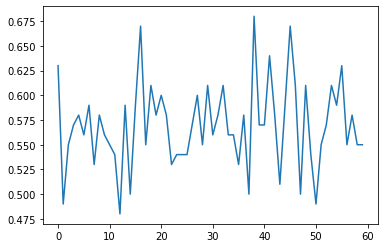

In [121]:
plt.plot(accuracies)

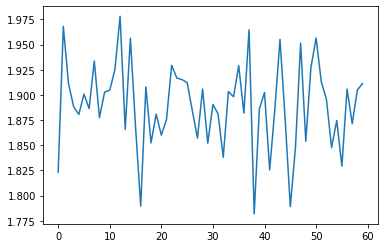

In [122]:
plt.plot(losses)